# Exploratory Analysis & Sector Correlation Studies

## 1. Import Packages and Setup Config

In [1]:
import sqlite3
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Config
DB_PATH = "../data/data.db"
PRICES_CSV = "../data/processed/prices_monthly.csv"
FEATURES_CSV = "../data/processed/features_monthly.csv"
MACRO_CSV = "../data/processed/macro_monthly.csv"

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

## 2. Load Data

In [2]:
def read_table(db_path: str, table: str, csv_fallback: str) -> pd.DataFrame:
    try:
        with sqlite3.connect(db_path) as conn:
            df = (pd.read_sql(f"SELECT * FROM {table}", conn, parse_dates=["date"])
                    .set_index("date")
                    .sort_index())
        print(f"Loaded '{table}' from SQLite DB at: {db_path}")
        return df
    except Exception as e:
        print(f"SQLite load failed for '{table}' ({e}); trying CSV fallback: {csv_fallback}")
        df = (pd.read_csv(csv_fallback, parse_dates=["date"])
                .set_index("date")
                .sort_index())
        print(f"Loaded '{table}' from CSV file at: {csv_fallback}")
        return df

prices = read_table(DB_PATH, "prices_monthly", PRICES_CSV)
features = read_table(DB_PATH, "features_monthly", FEATURES_CSV)
macro = read_table(DB_PATH, "macro_monthly", MACRO_CSV)

prices.head(), features.head(), macro.head()


Loaded 'prices_monthly' from SQLite DB at: ../data/data.db
Loaded 'features_monthly' from SQLite DB at: ../data/data.db
Loaded 'macro_monthly' from SQLite DB at: ../data/data.db


(                  XLF        XLK        XLE        XLV        XLI        XLP  \
 date                                                                           
 2000-01-31  11.278577  37.729050  13.894566  20.484612  17.143375  12.567067   
 2000-02-29  10.071249  41.693169  13.306357  19.145201  16.197536  11.096548   
 2000-03-31  11.910493  45.190922  14.961984  20.867306  18.452335  11.513701   
 2000-04-30  12.025533  41.040260  14.738663  20.622807  18.718904  12.124150   
 2000-05-31  12.293967  36.772991  16.469341  20.070034  18.639923  12.988940   
 
                   XLY        XLB        XLU        SPY  
 date                                                    
 2000-01-31  20.219391  13.111597  11.262787  88.175972  
 2000-02-29  19.092863  11.794288   9.893929  86.833328  
 2000-03-31  21.794836  12.984254  10.974713  95.248734  
 2000-04-30  21.341015  12.552916  11.693100  91.903587  
 2000-05-31  20.189016  12.156785  11.667451  90.458588  ,
              XLF_r1m   

## 3. Monthly Return by Sector

,count,mean,std,min,25%,50%,75%,max
XLF,307.0,0.0070,0.0611,-0.2620,-0.0240,0.0125,0.0411,0.2179
XLK,307.0,0.0085,0.0652,-0.2491,-0.0251,0.0159,0.0474,0.2477
XLE,307.0,0.0087,0.0727,-0.3437,-0.0297,0.0128,0.0484,0.3076
XLV,307.0,0.0070,0.0409,-0.1448,-0.0196,0.0106,0.0318,0.1259
XLI,307.0,0.0086,0.0540,-0.1863,-0.0202,0.0102,0.0392,0.1807
XLP,307.0,0.0067,0.0351,-0.1261,-0.0123,0.0097,0.0295,0.1045
XLY,307.0,0.0095,0.0555,-0.1763,-0.0186,0.0111,0.0440,0.1888
XLB,307.0,0.0081,0.0587,-0.2240,-0.0278,0.0095,0.0435,0.1734
XLU,307.0,0.0075,0.0439,-0.1472,-0.0144,0.0129,0.0377,0.1321
SPY,307.0,0.0075,0.0439,-0.1652,-0.0165,0.0128,0.0343,0.1270


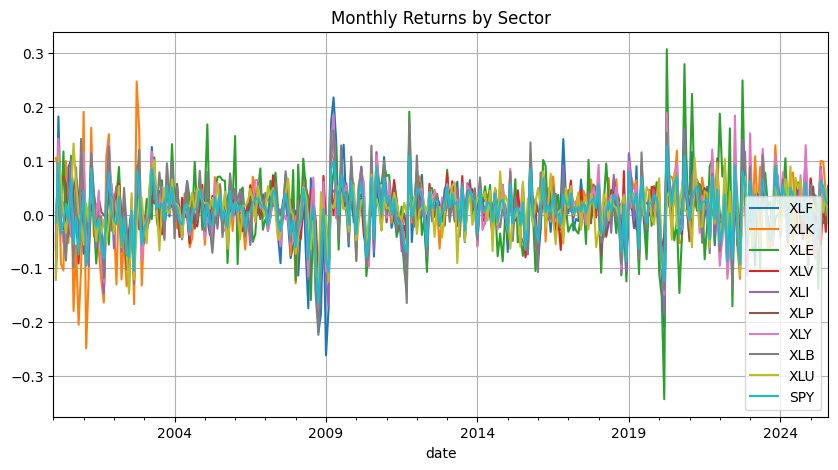

In [3]:
# Monthly Return by Sector
returns = prices.pct_change()
display(returns.describe().T.round(4))
# Plot a subset (or all) of sector return series
returns.plot(title="Monthly Returns by Sector")
plt.show()

The plot shows that most U.S. sector ETFs move closely together, indicating strong market-wide correlation driven by common factors. Defensive sectors such as XLU and Consumer Staples (XLP) exhibit the smallest fluctuations, while cyclical sectors like Energy (XLE) and Technology (XLK) show larger swings, reflecting higher sensitivity to macroeconomic changes. 

The sharp drop and rebound around 2020 correspond to the COVID-19 crash and recovery, while the increased amplitude of returns after 2021 highlights the volatility during the inflation and rate-hike period. 

Overall, SPY tracks near the sector average, confirming its role as the broad market benchmark.

## 4. Sector Correlation

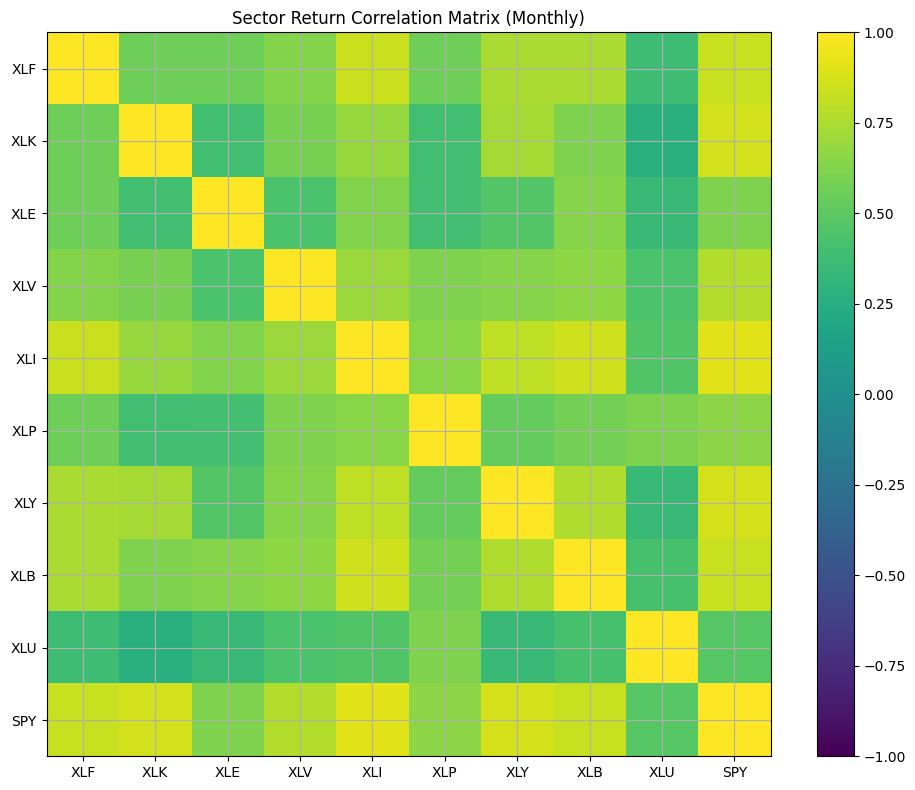

In [4]:
corr = returns.corr()

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr.values, vmin=-1, vmax=1)
ax.set_title("Sector Return Correlation Matrix (Monthly)")
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.index)))
ax.set_xticklabels(corr.columns)
ax.set_yticklabels(corr.index)
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

This correlation matrix shows that nearly all sectors have strong positive correlations with each other, generally ranging between 0.5 and 0.9, which reflects the broad market’s tendency to move in unison. 

The bright yellow cells along the off-diagonal indicate particularly high correlations (e.g., between Technology （XLK）, Consumer Discretionary [XLY], and Financials [XLF]), all of which are cyclical sectors that respond similarly to economic growth. Conversely, cooler green-blueareas such as those involving Energy [XLE] or Utilities [XLU] indicate weaker correlations, suggesting these sectors behave somewhat independently—Energy often diverges due to commodity price shocks, and Utilities act as a defensive hedge. 

SPY, as expected, is highly correlated with all sectors since it represents the aggregate market. Overall, the matrix confirms that sector performance is heavily synchronized, with only a few defensive or commodity-linked exceptions providing diversification.